# Tangles-CNN Training Notebook

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import json
from PIL import Image

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat import *

# Print basic stats
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.10.1
Torchvision Version:  0.11.2
CUDA status:  True
CUDA memory max alloc:        0 MB


## User parameters
Modify data location and parameters below to your specifications

In [2]:
# Top level data directory. Replace with the directory containing the output of organize_samples.sh 
# The directory must conform to the PyTorch ImageFolder structure
exp_dir = "/home/pauly2/cndr_histo/data/phf1/samples/exp03"

# Create a config object - this gets saved along with the model after training
# Please see Durand CVPR 2018 (WildCat paper) for meaning of kmin, kmax, alpha, num_maps
config = {
    "wildcat_upsample": {
        "kmax": 0.02,
        "kmin": 0.0,
        "alpha": 0.7,
        "num_maps": 4,
        "input_size": 224,
        "num_epochs": 30,
        "batch_size": 16
    }
}

## Dataloaders and Transforms

In [3]:
# Patch directory
data_dir = os.path.join(exp_dir, "patches")

# Transforms for training and validation
input_size = config['wildcat_upsample']['input_size']
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=config['wildcat_upsample']['batch_size'], 
                                                   shuffle=True, 
                                                   num_workers=4) for x in ['train', 'val']}

# Class to index mapping
class_to_index = dataloaders_dict['train'].dataset.class_to_idx
cnames = {v:k for k,v in class_to_index.items() }
n_classes = len(class_to_index)

tensor([3, 1, 1, 0, 2, 1, 1, 1, 3, 3, 2, 1, 3, 3, 2, 2])

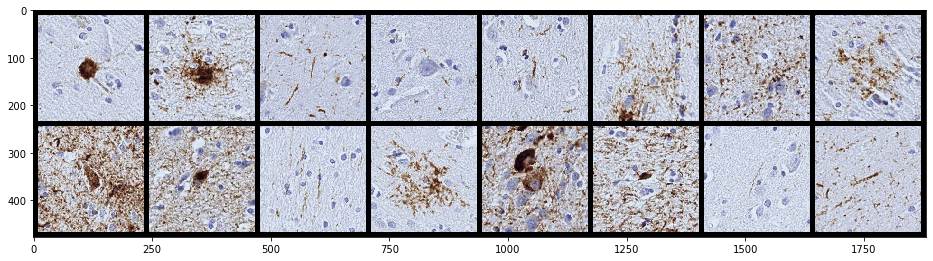

In [4]:
# Read a batch of data from the training data loader
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
img,label=next(iter(dataloaders_dict['train']))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))
label

## Model instantiation

In [5]:
config['num_classes'] = n_classes
model=resnet50_wildcat_upsample(
    config['num_classes'],
    pretrained=True, 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'], 
    num_maps=config['wildcat_upsample']['num_maps'])

# Loss and optimizer
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(model.get_config_optim(0.01, 0.1), lr=0.01, momentum=0.9, weight_decay=1e-2)

In [6]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [13]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], n_classes])
                for i in range(n_classes):
                    labels_one_hot[:, i] = (labels == i)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [14]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=config['wildcat_upsample']['num_epochs'])

Epoch 0/29
----------
train Loss: 0.4091 Acc: 0.6746
val Loss: 0.2600 Acc: 0.8063

Epoch 1/29
----------
train Loss: 0.2155 Acc: 0.8680
val Loss: 0.1520 Acc: 0.9200

Epoch 2/29
----------
train Loss: 0.1622 Acc: 0.9078
val Loss: 0.1610 Acc: 0.9113

Epoch 3/29
----------
train Loss: 0.1562 Acc: 0.9102
val Loss: 0.1502 Acc: 0.9138

Epoch 4/29
----------
train Loss: 0.1406 Acc: 0.9191
val Loss: 0.1409 Acc: 0.9138

Epoch 5/29
----------
train Loss: 0.1326 Acc: 0.9266
val Loss: 0.1133 Acc: 0.9450

Epoch 6/29
----------
train Loss: 0.1209 Acc: 0.9395
val Loss: 0.1995 Acc: 0.8762

Epoch 7/29
----------


KeyboardInterrupt: 

## Export model

In [18]:
# Save the model using a format that can be read using production-time scripts
model_dir = os.path.join(exp_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model_ft.state_dict(), os.path.join(model_dir, "wildcat_upsample.dat"))

# Save the configuration
with open(os.path.join(model_dir, 'config.json'), 'w') as jfile:
    json.dump(config, jfile)

Model performance over epochs

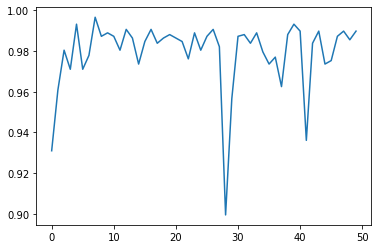

In [11]:
plt.plot(hist)

In [12]:
del model_ft
torch.cuda.empty_cache()

In [13]:
!nvidia-smi

Mon Dec 14 16:12:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    49W / 250W |   2079MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------